In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

print("All libraries imported successfully.")


All libraries imported successfully.


In [87]:
df = pd.read_csv("Telco-Customer-Churn.csv")

In [88]:
# Convert TotalCharges to numeric and handle missing values
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
df.fillna(df["TotalCharges"].median(), inplace=True)

df.drop(columns=["customerID"], inplace=True)

# Fix "No internet service" and "No phone service" issues
replace_cols = ["MultipleLines", "OnlineSecurity", "OnlineBackup", 
                "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
for col in replace_cols:
    df[col] = df[col].replace({"No internet service": "No", "No phone service": "No"})

# Ensure SeniorCitizen is treated as a numeric feature
df["SeniorCitizen"] = df["SeniorCitizen"].astype(int)

# Encode categorical features using one-hot encoding
df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)
df = pd.get_dummies(df, drop_first=True)

# Scale numerical features
scaler = StandardScaler()
num_features = ["tenure", "MonthlyCharges", "TotalCharges"]
df[num_features] = scaler.fit_transform(df[num_features])

print("Data cleaning and encoding completed successfully!")

Data cleaning and encoding completed successfully!


In [ ]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Apply PCA
pca = PCA(n_components=0.95)  # Preserve at least 95% of the variance
X_pca = pca.fit_transform(X)

print(f"PCA reduced {X.shape[1]} features to {X_pca.shape[1]} while preserving 95% variance.")

PCA reduced 23 features to 22 while preserving 95% variance.


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

print("Train-Test split completed.")

Train-Test split completed.


In [91]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)

baseline_acc = accuracy_score(y_test, y_pred_log)

print(f"Baseline Model Accuracy: {baseline_acc:.4f}")
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_log))

Baseline Model Accuracy: 0.8020
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



In [92]:
base_learner = DecisionTreeClassifier(max_depth=2)

adaboost = AdaBoostClassifier(estimator=base_learner, n_estimators=100, learning_rate=0.1, random_state=42)
adaboost.fit(X_train, y_train)

y_pred_ada = adaboost.predict(X_test)

print("AdaBoost Model Performance:")
print(classification_report(y_test, y_pred_ada))

AdaBoost Model Performance:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.65      0.47      0.54       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



In [93]:
mlp_model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

mlp_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print("MLP Model Built Successfully.")

MLP Model Built Successfully.


In [94]:
history = mlp_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6707 - loss: 0.5928 - val_accuracy: 0.7899 - val_loss: 0.4380
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.8054 - loss: 0.4249 - val_accuracy: 0.7956 - val_loss: 0.4283
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.7935 - loss: 0.4353 - val_accuracy: 0.7999 - val_loss: 0.4256
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.7973 - loss: 0.4257 - val_accuracy: 0.7935 - val_loss: 0.4250
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.8032 - loss: 0.4138 - val_accuracy: 0.7928 - val_loss: 0.4233
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.7973 - loss: 0.4253 - val_accuracy: 0.7984 - val_loss: 0.4236
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.8103 - loss: 0.4074 - val_accuracy: 0.7991 - val_loss: 0.4209
Epoch 8/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.8072 - loss: 0.4

In [95]:
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
y_probs_mlp = mlp_model.predict(X_test).flatten()
y_pred_mlp = (y_probs_mlp >= 0.5).astype(int)
print(f"MLP Test Accuracy: {test_acc:.4f}")
print(classification_report(y_test, y_pred_mlp))


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.7633 - loss: 0.4488
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
MLP Test Accuracy: 0.7786
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1035
           1       0.61      0.47      0.53       374

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


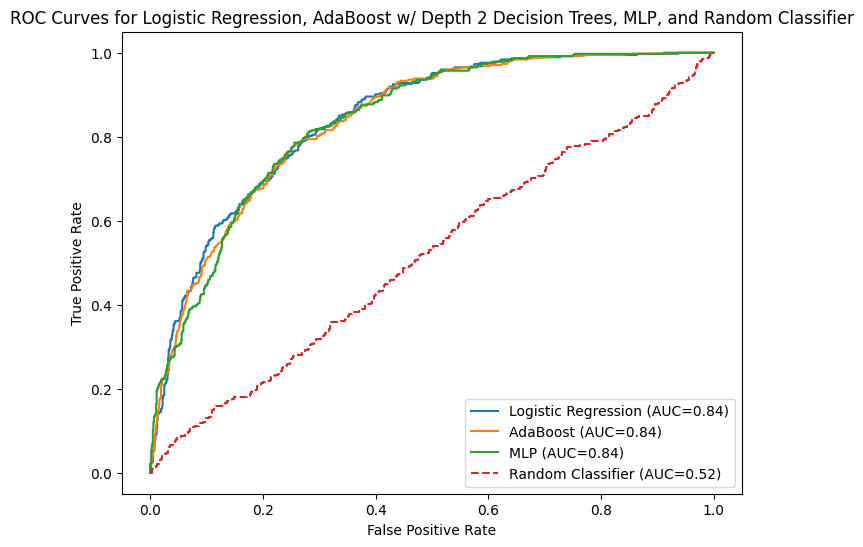

In [96]:
# Get probabilities
y_probs_log = log_model.predict_proba(X_test)[:, 1]
y_probs_ada = adaboost.predict_proba(X_test)[:, 1]
y_probs_mlp = mlp_model.predict(X_test).flatten()

# Compute ROC Curve
fpr_log, tpr_log, _ = roc_curve(y_test, y_probs_log)
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_probs_ada)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_probs_mlp)


# Random classifier
y_probs_random = np.random.rand(len(y_test))
fpr_random, tpr_random, _ = roc_curve(y_test, y_probs_random)

# Plot ROC Curves
plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC={auc(fpr_log, tpr_log):.2f})")
plt.plot(fpr_ada, tpr_ada, label=f"AdaBoost (AUC={auc(fpr_ada, tpr_ada):.2f})")
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC={auc(fpr_mlp, tpr_mlp):.2f})")
plt.plot(fpr_random, tpr_random, label=f"Random Classifier (AUC={auc(fpr_random, tpr_random):.2f})", linestyle='--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Logistic Regression, AdaBoost w/ Depth 2 Decision Trees, MLP, and Random Classifier")
plt.show()